# Neural Style Transfer for Videos

This is an **naive implementation** for applying neural style transfer for videos. Here `neural style transfer is applied to every frame of the video` and a new video is created with the applied style with the content of the original video. The way I've applied neural style transfer on a frame of the video is the same as we apply on a single image (since an individual frame is just an image).

For this project I've used the `pre-trained model` from **Tensorflow Hub** which will allow us to perform **Fast Style Transfer**, though custom models can be used but applying style to them will be quite time consuming as compared to the method used here. To know about Tensorflow Hub and custom models for Neural Style Transfer for Images follow the this [kernel](https://www.kaggle.com/akashsdas/neural-style-transfer-for-images).

In [1]:
import os
import time
import functools

import IPython.display as display
from IPython.display import clear_output

import cv2
import PIL.Image

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

import tensorflow as tf

import tensorflow_hub as hub

In [2]:
# Load compressed models from tensorflow_hub
os.environ['TFHUB_MODEL_LOAD_FORMAT'] = 'COMPRESSED'

In [3]:
# Loading the Tensorflow Hub model for Fast Style Transfer
hub_model = hub.load('https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2')

## Helper functions

In [4]:
def load_img(path_to_img):
    # Instead of max_dim, frame's height and width can be passed for the resizing
    # step in this function, also 640px is height, width dims for the `fox.mp4` video
    # That's why I've kept max_dim as 640
    max_dim = 640
    
    img = tf.io.read_file(path_to_img)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    # removing the channel dim and getting other dims from the img shape
    shape = tf.cast(tf.shape(img)[:-1], tf.float32)  
    
    # getting the biggest dim in img shape
    long_dim = max(shape)
    
    # creating a factor to scale down the long_dim to less than equal to max_dim
    scale = max_dim / long_dim
    
    # scaling down all dims in the shape tensor, specailly making the long_dim
    # to size equal to max_dim
    new_shape = tf.cast(shape * scale, tf.int32)
    
    # resizing the img
    img = tf.image.resize(img, new_shape)  
    
    # adding a batch size (240, 240, 3) => (1, 240, 240, 3)
    img = img[tf.newaxis, :]
    return img

In [5]:
# To plot img
def imshow(image, title=None):
    if len(image.shape) > 3:
        # removing the batch shape
        image = tf.squeeze(image, axis=0)
    
    plt.imshow(image)
    if title:
        plt.title(title)

We have to `process the output (styled images) given by the tensorflow hub model` so that we can write that image as a frame on to our output styled video.

In [6]:
def process_tfhub_output(tensor):
    # scaling the img values between 0-255 as the imgs values are 
    # currently between 0-1
    tensor = tensor * 255
    
    tensor = np.array(tensor, dtype=np.uint8)
    
    if np.ndim(tensor) > 3:
        assert tensor.shape[0] == 1   # checking for batch size to be 1 (individual img)
        tensor = tensor[0]            # getting the img from the batch of size 1
    return tensor

## Neural Style Transfer using Tensorflow Hub model

Tensorflow Hub's Fast Style Transfer model results on images

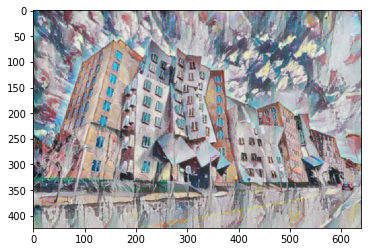

In [7]:
content_img = load_img('../input/neural-style-transfer-data/content/stata.jpg')
style_img = load_img('../input/neural-style-transfer-data/style/aquarelle.jpg')
styled_img = hub_model(tf.constant(content_img), tf.constant(style_img))[0]
imshow(styled_img)

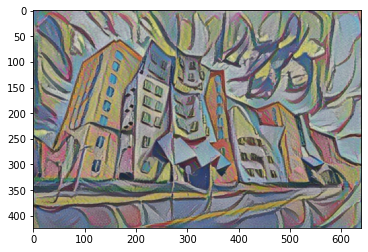

In [8]:
content_img = load_img('../input/neural-style-transfer-data/content/stata.jpg')
style_img = load_img('../input/neural-style-transfer-data/style/la_muse.jpg')
styled_img = hub_model(tf.constant(content_img), tf.constant(style_img))[0]
imshow(styled_img)

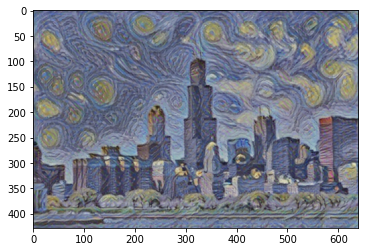

In [9]:
content_img = load_img('../input/neural-style-transfer-data/content/chicago.jpg')
style_img = load_img('../input/neural-style-transfer-data/style/bango.jpg')
styled_img = hub_model(tf.constant(content_img), tf.constant(style_img))[0]
imshow(styled_img)

Of course results won't be amazing but you'll get the advantage of speed. Results can be improved by using a custom model and tuning the hyperparameters for the Neural Style Transfer algorithm. 

In [10]:
def nst_using_tfhub_model(video_path, style_img, output_video_name='output.avi', num_of_frames=None):
    capture = cv2.VideoCapture(video_path)
    
    # Checking if the video can be used or not
    if not capture.isOpened():
        print(f'Could not open the video: {video_path}')
        sys.exit(-1)
        
    # Getting video frame info
    frame_width = int(capture.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(capture.get(cv2.CAP_PROP_FRAME_HEIGHT))
    frame_count = capture.get(cv2.CAP_PROP_FRAME_COUNT)
    video_info_str = f'Video frame resolution: width={frame_width} height={frame_height} of frame count={frame_count}'
    print(video_info_str)

    # Starting with frame number
    frame_num = -1
    
    output_video = cv2.VideoWriter(
        output_video_name,
        apiPreference=0,
        fourcc=cv2.VideoWriter_fourcc('M','J','P','G'),
        fps=20,
        frameSize=(frame_width, frame_height)
    )
    
    # Applying NST upto a specific frame number, if style is applied on the entire video then 
    # it will take time, but with Fast NST it will take less as compared to custom model
    till_frame = num_of_frames if num_of_frames else frame_count
    
    # All the frames info
    styled_frame_pct = ((frame_num + 1) / (till_frame + 1)) * 100
    frame_info_str = f'{styled_frame_pct}% '
    print(frame_info_str)
    
    while frame_num < till_frame - 1:
        _, frame = capture.read()

        if frame is None:
            print('DONE!!!')
            break

        frame_num += 1
        # print(f'Frame {frame_num+1} of {till_frame}')

        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        plt.imsave(f'frame.png', frame, format='png')
        content_img = load_img(f'frame.png')

        # cv2.waitKey(1) # This line causes error
        # error: OpenCV(4.5.1) /tmp/pip-req-build-tk9iuyva/opencv/modules/highgui/src/window.cpp:717: error: (-2:Unspecified error) The function is not implemented. Rebuild the library with Windows, GTK+ 2.x or Cocoa support. If you are on Ubuntu or Debian, install libgtk2.0-dev and pkg-config, then re-run cmake or configure script in function 'cvWaitKey'

        # applying neural style transfer on a frame
        styled_frame = hub_model(tf.constant(content_img), tf.constant(style_img))[0]

        plt.imsave(
            'frame.png', 
            process_tfhub_output(styled_frame), 
            format='png'
        )

        mat = cv2.imread(
            f'frame.png', 
            cv2.IMREAD_COLOR
        )
        umat = cv2.UMat(mat)
        output_video.write(umat)
        
        # Updating frame info that is printed on to output
        clear_output(wait=True)
        styled_frame_pct = ((frame_num + 1) / (till_frame + 1)) * 100
        frame_info_str = f"{round(styled_frame_pct, 2)}% {int(styled_frame_pct) * '='}"
        print(video_info_str)
        print(frame_info_str)


    # Releasing the resources
    output_video.release()

#### Udnie Style 

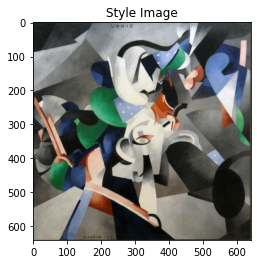

In [11]:
style_img_path = '../input/neural-style-transfer-data/style/udnie.jpg'
style_img = load_img(style_img_path)
imshow(style_img, 'Style Image')

In [12]:
nst_using_tfhub_model(
    '../input/neural-style-transfer-data/content/fox.mp4',
    style_img,
    output_video_name='fox-udnie-style-video.avi'
)

Video frame resolution: width=640 height=640 of frame count=420.0
99.76% ===================================================================================================


#### Bango Style

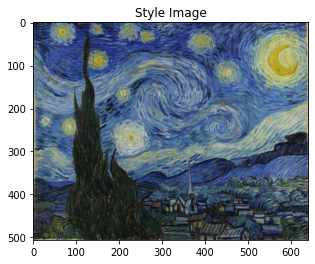

In [13]:
style_img_path = '../input/neural-style-transfer-data/style/bango.jpg'
style_img = load_img(style_img_path)
imshow(style_img, 'Style Image')

In [14]:
nst_using_tfhub_model(
    '../input/neural-style-transfer-data/content/fox.mp4',
    style_img,
    output_video_name='fox-bango-style-video.avi'
)

Video frame resolution: width=640 height=640 of frame count=420.0
99.76% ===================================================================================================


#### The Scream Style

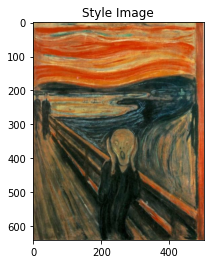

In [15]:
style_img_path = '../input/neural-style-transfer-data/style/the_scream.jpg'
style_img = load_img(style_img_path)
imshow(style_img, 'Style Image')

In [16]:
nst_using_tfhub_model(
    '../input/neural-style-transfer-data/content/fox.mp4',
    style_img,
    output_video_name='fox-the-scream-style-video.avi'
)

Video frame resolution: width=640 height=640 of frame count=420.0
99.76% ===================================================================================================


#### La Muse Style

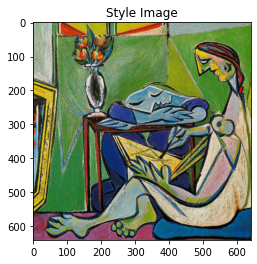

In [17]:
style_img_path = '../input/neural-style-transfer-data/style/la_muse.jpg'
style_img = load_img(style_img_path)
imshow(style_img, 'Style Image')

In [18]:
nst_using_tfhub_model(
    '../input/neural-style-transfer-data/content/fox.mp4',
    style_img,
    output_video_name='fox-la-muse-style-video.avi'
)

Video frame resolution: width=640 height=640 of frame count=420.0
99.76% ===================================================================================================


---

I'll wrap things up there. If you have any `questions` then do let me know.

If this kernel helped you then don't forget to 🔼 **upvote** and share your 🎙 **feedback** on improvements of the kernel.

![](https://media.giphy.com/media/qWoubkSvQxN1C/giphy.gif)